In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
import time

import Featurizer as ft

warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
pd.set_option('display.max_columns', 50)


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [3]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [12.0,8.0]

In [4]:
import category_encoders as ce

OHE = ce.OneHotEncoder( handle_unknown='ignore', use_cat_names=True)
BE = ce.BinaryEncoder( handle_unknown='ignore')
HE = ce.HashingEncoder( )
TE1 = ce.TargetEncoder( handle_unknown='ignore')
TE2 = ce.TargetEncoder( handle_unknown='ignore')
TE3 = ce.TargetEncoder( handle_unknown='ignore')
TE4 = ce.TargetEncoder( handle_unknown='ignore')

In [5]:
df_train = pd.read_csv("../data/palabras.csv")

#df_feature_descripcion = pd.read_csv("../data/word-features-reduced.csv", dtype=np.float16)

#df_train = df_train.join(df_feature_descripcion)

In [6]:
df_train["ambientes"] = df_train["banos"] + df_train["habitaciones"]

## Pre-processing

In [8]:
X = df_train.drop("precio", axis=1)
y = df_train['precio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [9]:
X_train_submit = X_train.copy()

In [10]:
X_train[ ft.getTarget1Cols() ] = X_train[ft.getAllCols()]
X_test[ ft.getTarget1Cols() ] = X_test[ft.getAllCols()]

X_train[ ft.getTarget2Cols() ] = X_train[ft.getAllCols()]
X_test[ ft.getTarget2Cols() ] = X_test[ft.getAllCols()]

X_train[ ft.getTarget3Cols() ] = X_train[ft.getAllCols()+['habitaciones','ambientes']]
X_test[ ft.getTarget3Cols() ] = X_test[ft.getAllCols()+['habitaciones','ambientes']]

X_train[ ft.getTarget4Cols() ] = X_train[ft.getAllCols()+['habitaciones','ambientes']]
X_test[ ft.getTarget4Cols() ] = X_test[ft.getAllCols()+['habitaciones','ambientes']]

In [11]:
X_train_ant = X_train["antiguedad"]
X_test_ant = X_test["antiguedad"]

In [12]:
X_train = ft.preprocess(X_train, OHE, BE, 'train', TE1, TE2, TE3, TE4, y_train, X_train_ant)
X_test = ft.preprocess(X_test, OHE, BE, 'test', TE1, TE2, TE3, TE4)

--- 11.896728038787842 seconds ---
--- 1.662968397140503 seconds ---


In [13]:
X_train["banoshabit"] = X_train["banos"]/X_train["habitaciones"]
X_test["banoshabit"] = X_test["banos"]/X_test["habitaciones"]

In [14]:
print(f"Original shapes: X={X.shape} y={y.shape}")
print(f"Train shapes: X={X_train.shape} y={y_train.shape}")
print(f"Test  shapes: X={X_test.shape}  y=-{y_test.shape}")

Original shapes: X=(240000, 115) y=(240000,)
Train shapes: X=(180000, 205) y=(180000,)
Test  shapes: X=(60000, 205)  y=-(60000,)


In [15]:
X_train

,id,tipodepropiedad_Casa en condominio,tipodepropiedad_Casa,tipodepropiedad_Apartamento,tipodepropiedad_Terreno,tipodepropiedad_Local Comercial,tipodepropiedad_Quinta Vacacional,tipodepropiedad_Bodega comercial,tipodepropiedad_Otros,tipodepropiedad_Oficina comercial,tipodepropiedad_Terreno comercial,tipodepropiedad_Local en centro comercial,tipodepropiedad_Edificio,tipodepropiedad_Duplex,tipodepropiedad_Terreno industrial,tipodepropiedad_Villa,tipodepropiedad_Nave industrial,tipodepropiedad_Casa uso de suelo,tipodepropiedad_Inmuebles productivos urbanos,tipodepropiedad_Departamento Compartido,tipodepropiedad_Rancho,tipodepropiedad_Huerta,tipodepropiedad_nan,tipodepropiedad_Lote,tipodepropiedad_Hospedaje,...,provincia_target_precio,ciudad_target_antiguedad,idzona_target_antiguedad,tipodepropiedad_target_antiguedad,provincia_target_antiguedad,ciudad_target_m2,idzona_target_m2,tipodepropiedad_target_m2,provincia_target_m2,habitaciones_m2,ambientes_m2,ciudad_target_m2_log,idzona_target_m2_log,tipodepropiedad_target_m2_log,provincia_target_m2_log,habitaciones_m2_log,ambientes_m2_log,metroscubiertostotales,m_tot_log,m_cub_log,m2_log,m_tot_sqrt,m_cub_sqrt,m2_sqrt,banoshabit
122812,298880,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2.400434e+06,4.877330,7.380053,6.267686,4.531339,375.094215,377.194376,367.956936,372.230705,381.860126,332.897388,375.094215,377.194376,367.956936,372.230705,381.860126,332.897388,330.0,5.075174,5.135798,5.799093,12.649111,13.038405,18.165902,0.666667
180398,87355,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1.460238e+06,8.305556,8.112165,8.268373,5.871437,415.065217,357.518750,391.155764,373.059243,203.103264,237.537597,415.065217,357.518750,391.155764,373.059243,203.103264,237.537597,296.0,5.049856,4.941642,5.690359,12.489996,11.832160,17.204651,1.000000
157317,141560,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3.474495e+06,10.688662,8.816850,8.373438,12.181636,258.501867,232.743333,236.866826,314.021226,381.860126,332.897388,258.501867,232.743333,236.866826,314.021226,381.860126,332.897388,186.0,4.532599,4.532599,5.225747,9.643651,9.643651,13.638182,0.666667
78425,63104,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2.763384e+06,10.245330,15.173913,8.268373,9.995179,262.134533,201.956522,391.155764,365.280693,381.860126,237.537597,262.134533,201.956522,391.155764,365.280693,381.860126,237.537597,198.0,4.442651,4.727388,5.288267,9.219544,10.630146,14.071247,0.333333
73755,260795,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3.474495e+06,15.029070,11.052632,8.268373,12.181636,335.557813,353.341772,391.155764,314.021226,499.763899,458.742789,335.557813,353.341772,391.155764,314.021226,499.763899,458.742789,550.0,5.991465,5.010635,6.309918,20.000000,12.247449,23.452079,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,271551,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2.400434e+06,4.877330,3.258065,8.268373,4.531339,375.094215,533.666667,391.155764,372.230705,381.860126,458.742789,375.094215,533.666667,391.155764,372.230705,381.860126,458.742789,407.0,5.416100,5.204007,6.008813,15.000000,13.490738,20.174241,1.000000
103694,151225,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2.763384e+06,6.304428,4.950000,8.268373,9.995179,191.789565,114.300001,391.155764,365.280693,203.103264,165.378004,191.789565,114.300001,391.155764,365.280693,203.103264,165.378004,118.0,4.077537,4.077537,4.770685,7.681146,7.681146,10.862780,0.500000
131932,245245,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2.370589e+06,5.313059,6.303030,8.268373,6.662689,294.947867,271.727273,391.155764,348.827385,381.860126,332.897388,294.947867,271.727273,391.155764,348.827385,381.860126,332.897388,210.0,4.653960,4.653960,5.347108,10.246951,10.246951,14.491377,0.666667
146867,154866,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

## Training

In [16]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=1750,n_jobs=6,objective="reg:squarederror", max_depth= 11,min_child_weight = 1,colsample_bytree=0.5, gamma=1, learning_rate=0.1, subsample=1,)
model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=1,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=11, min_child_weight=1, missing=None, n_estimators=1750,
             n_jobs=6, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [17]:
start_time = time.time()
model.fit(X_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

--- 1395.8624737262726 seconds ---


## Predicciones

In [18]:
ft.predecir(model, X_train, y_train, X_test, y_test)

Entrenamiento: 99.9618%
Testeo: 83.8650%.
Mean abs error: 493017.4795.


In [19]:
plt.rcParams["figure.figsize"] = [15, 15]

importancia = model.feature_importances_

d = {'x':X_train.columns,'y':importancia}

df_importancia = pd.DataFrame(d)

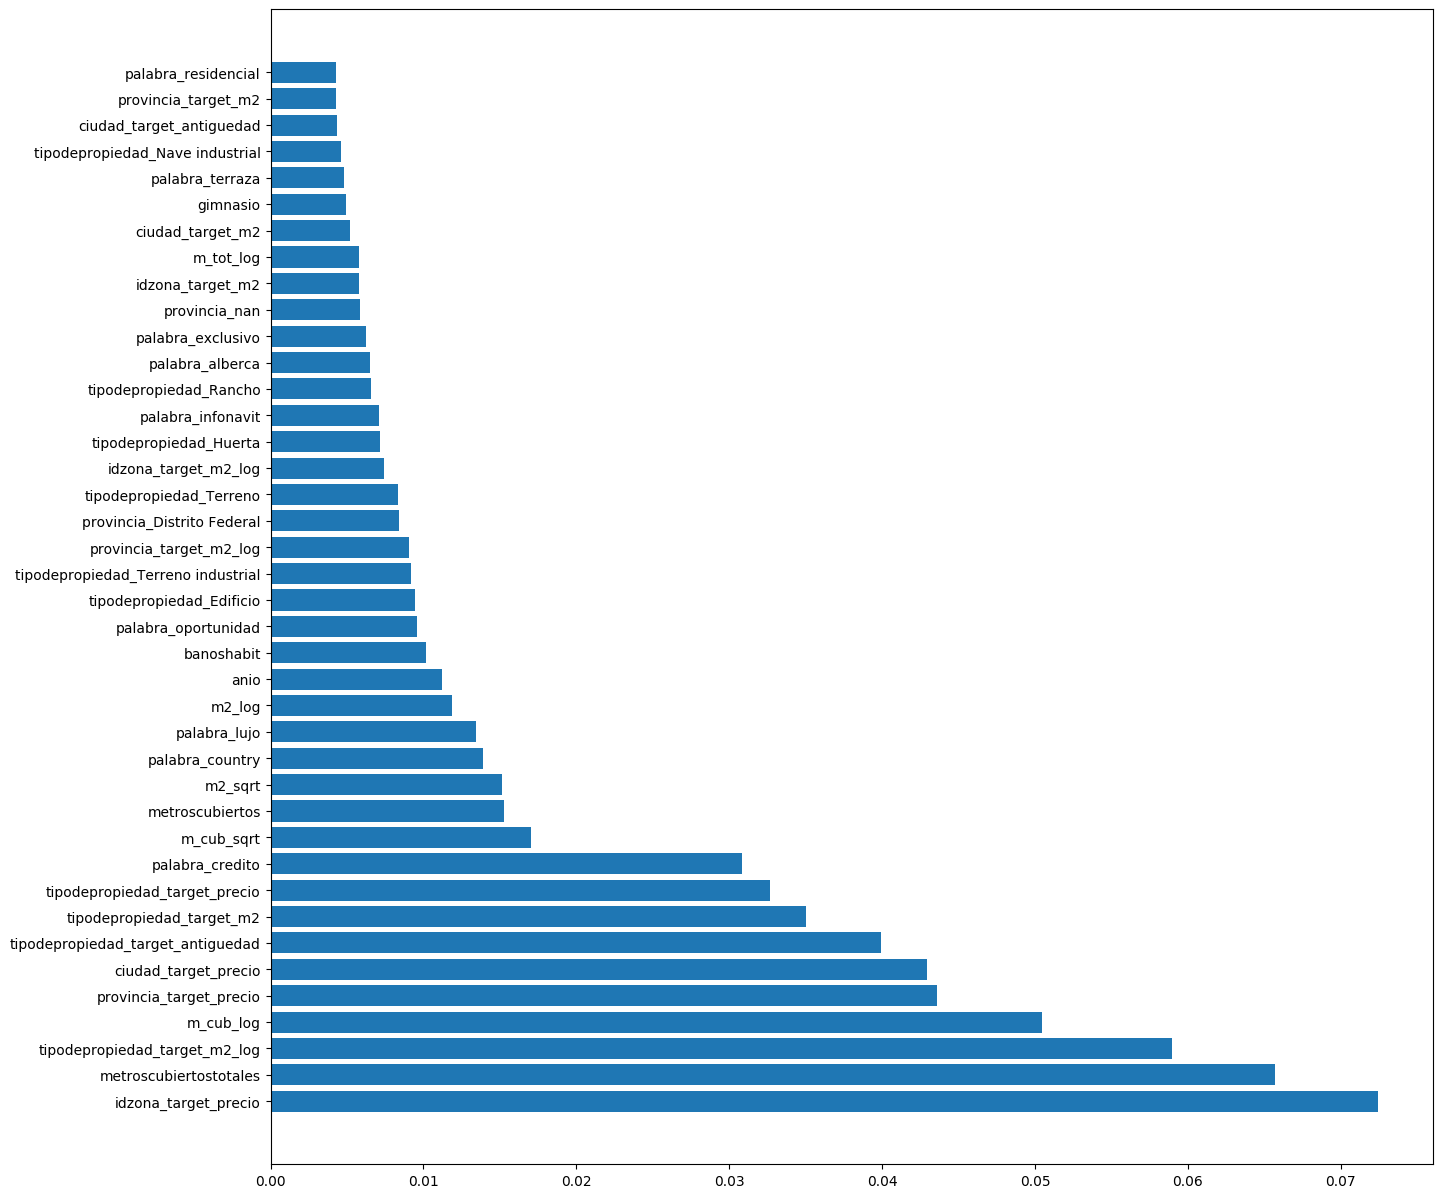

In [20]:
importancia = df_importancia.sort_values(by="y",ascending=False).head(40)
ax = plt.barh(importancia.x,importancia.y)

## Submission

In [28]:
df_test = pd.read_csv('../data/test.csv')

In [29]:
df = df_test.copy()
df = ft.init_test(df)
df["ambientes"] = df["banos"] + df["habitaciones"]


In [30]:
df[ ft.getTarget1Cols() ] = df[ft.getAllCols()]
df[ ft.getTarget2Cols() ] = df[ft.getAllCols()]
df[ ft.getTarget3Cols() ] = df[ft.getAllCols()+['habitaciones','ambientes']]

In [31]:
df = ft.preprocess(df, OHE, BE, 'test', TE1, TE2, TE3, TE4)

--- 1.3208162784576416 seconds ---


In [32]:
df["banoshabit"] = df["banos"]/df["habitaciones"]

In [33]:
#df, X_train = df.align(X_train,axis=1)


In [34]:
submit_prediction = model.predict( df )

In [35]:
#cols_diff = []
#t = X_train_submit.columns.values
#fs = df.columns.values
#i = 0
#for feat in t:
#    if feat != fs[i]:
#        cols_diff.append(feat)
#    i=+1
#display(cols_diff)        

In [ ]:
#pd.concat([df_test[['id']], pd.Series(submit_prediction)], axis=1).rename(columns={0:"target"}).to_csv("../data/submission13.csv", index=False)

In [36]:
from submission_helper import submission_output

output = submission_output(df_test, submit_prediction)

nombre_submit = 'submission28.csv'

output.to_csv('../data/'+nombre_submit, index=False)